In [ ]:
import pandas as pd

# 파일 경로
file_path = '/content/sample_data/다중회귀_복합SCFI_2017.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataframe
data.head()


,YYYYMM,CH_EXP,FLEET_DEV,CNTR_TIMECHART,WTI,R_GDP_WORLD,DEFLATOR_WORLD,R_GDP_USA,CLI_USA,PMI_US,DEFLATOR_USA,G_RELI,G_DELAY,SCFI_C
0,2014-01,21790540,17312194,46.79983,94.6,1.787676e+07,109.776667,4173.316667,100.7090,53.7,102.690000,0.694882,3.948304,1174.866
1,2014-02,9977430,17385239,46.71077,100.8,1.791018e+07,110.063333,4168.433333,100.7202,57.1,102.830000,0.681136,4.267981,1069.362
2,2014-03,17115050,17367549,46.70015,100.8,1.794359e+07,110.350000,4163.550000,100.7613,55.5,102.970000,0.721154,3.897523,969.145
3,2014-04,20089670,17534040,47.20250,102.1,1.799153e+07,110.543333,4181.376667,100.8148,55.4,103.163333,0.732795,3.648607,1078.462
4,2014-05,20500550,17701139,46.95479,102.2,1.803947e+07,110.736667,4199.203333,100.8649,56.4,103.356667,0.753047,3.736327,1137.112


# 도표 20-6. 랜덤포레스트 수행을 위한 원-핫 인코딩 파이썬 코드

In [ ]:
# YYYYMM 열을 날짜 형식으로 변환한 후 월 정보만 추출한다.
data['Month'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m').dt.month

# Month 열을 기반으로 원-핫 인코딩 수행. 첫 번째 열(1월)은 제외한다.
month_one_hot = pd.get_dummies(data['Month'], prefix='Month').iloc[:, 1:]

# 원본 데이터프레임에 원-핫 인코딩된 컬럼들을 추가한다.
data_with_months = data.join(month_one_hot)
data_with_months.head()   # 여기서는 5행 , 26개 칼럼이 출력된다.


,YYYYMM,CH_EXP,FLEET_DEV,CNTR_TIMECHART,WTI,R_GDP_WORLD,DEFLATOR_WORLD,R_GDP_USA,CLI_USA,PMI_US,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,2014-01,21790540,17312194,46.79983,94.6,1.787676e+07,109.776667,4173.316667,100.7090,53.7,...,False,False,False,False,False,False,False,False,False,False
1,2014-02,9977430,17385239,46.71077,100.8,1.791018e+07,110.063333,4168.433333,100.7202,57.1,...,False,False,False,False,False,False,False,False,False,False
2,2014-03,17115050,17367549,46.70015,100.8,1.794359e+07,110.350000,4163.550000,100.7613,55.5,...,True,False,False,False,False,False,False,False,False,False
3,2014-04,20089670,17534040,47.20250,102.1,1.799153e+07,110.543333,4181.376667,100.8148,55.4,...,False,True,False,False,False,False,False,False,False,False
4,2014-05,20500550,17701139,46.95479,102.2,1.803947e+07,110.736667,4199.203333,100.8649,56.4,...,False,False,True,False,False,False,False,False,False,False


# 도표 20-7. RamdomForestRegressor 모듈 설치와 테스트 준비 파이썬 코드

In [ ]:
from sklearn.model_selection import train_test_split  #데이터를 훈련데이터와  테스트데이터로 분할하는 기능
from sklearn.ensemble import RandomForestRegressor  # 랜덤포레스트 회귀모형 구현
from sklearn.metrics import mean_squared_error  # 모델 성능 평가를 위한 평균제곱오차 계산 기능
import numpy as np

# 'YYYYMM', 'SCFI_C', 'Month' 컬럼을 제외한 나머지를 독립 변수(X)로 설정한다.
X = data_with_months.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)
# 종속 변수(y)로 'SCFI_C'를 사용한다.
y = data_with_months['SCFI_C']

# 데이터의 마지막 6개 행을 테스트 데이터로 분리하고 나머지를 훈련 데이터로 사용한다.
X_train, X_test = X[:-6], X[-6:]
y_train, y_test = y[:-6], y[-6:]

# 도표 20-8. 랜덤포레스트의 하이퍼파라미터 최적화 파이썬 코드

In [ ]:
# 그리드 서치를 통한 하이퍼파라미터 최적화 기능 제공
from sklearn.model_selection import GridSearchCV

# 랜덤 포레스트 모델에 대한 하이퍼파라미터 그리드를 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 결정 트리의 개수
    'max_depth': [10, 20, 30],       # 트리의 최대 깊이
    'min_samples_split': [2, 4, 6],  # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]    # 리프 노드가 되기 위한 최소 샘플 수
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
rf = RandomForestRegressor(random_state=0)  # 랜덤 포레스트 회귀 모델 초기화

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                      # 3-겹 교차 검증 사용
    n_jobs=-1,                 # 모든 CPU 코어 사용
    scoring='neg_mean_squared_error'  # 평가 기준으로 평균 제곱 오차의 음수 값 사용
)
grid_search.fit(X_train, y_train)  # 그리드 서치 수행

# 최적의 파라미터 추출
best_params = grid_search.best_params_
best_params


{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [ ]:
rf

RandomForestRegressor(random_state=0)

In [ ]:
print(grid_search.best_estimator_)
best_rf = grid_search.best_estimator_
# 최적의 모델의 파라미터를 추출합니다.
params = best_rf.get_params()

# 그리드 서치에 포함된 파라미터 중 None이 아닌 파라미터만 필터링하여 출력합니다.
filtered_params = {param: value for param, value in params.items() if param in param_grid and value is not None}
print(filtered_params)

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=0)
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


# 도표 20-9. 랜덤포레스트 모형 학습과 테스트 파이쎤 코드

In [ ]:
# GridSearchCV로부터 최적의 하이퍼파라미터를 사용하여 랜덤 포레스트 모델을 학습합니다.
best_rf_model = RandomForestRegressor(
    max_depth=10,               # 트리의 최대 깊이를 10으로 설정
    min_samples_leaf=1,         # 리프 노드가 되기 위한 최소 샘플 수를 1로 설정
    min_samples_split=2,        # 노드를 분할하기 위한 최소 샘플 수를 2로 설정
    n_estimators=50,            # 사용할 결정 트리의 수를 50으로 설정
    random_state=0              # 결과의 일관성을 위해 난수 생성기의 시드 값을 0으로 설정
)
best_rf_model.fit(X_train, y_train)  # 훈련 데이터로 모델 학습

# 최적의 모델을 사용하여 훈련 데이터와 테스트 데이터에 대한 예측 수행
y_train_pred_best = best_rf_model.predict(X_train)  # 훈련 데이터 예측
y_test_pred_best = best_rf_model.predict(X_test)    # 테스트 데이터 예측

# 전체 데이터셋에 대해 예측을 수행
y_pred_full_best = best_rf_model.predict(X)  # 전체 데이터 예측

# 훈련 데이터와 테스트 데이터에 대한 RMSE 계산
rmse_train_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))  # 훈련 데이터의 RMSE
rmse_test_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))     # 테스트 데이터의 RMSE

# 전체 데이터셋에 대한 RMSE 계산
rmse_full_best = np.sqrt(mean_squared_error(y, y_pred_full_best))          # 전체 데이터의 RMSE

# RMSE 결과를 소수점 둘째자리까지 출력
print(f"rmse_train_best: {rmse_train_best:.2f}, rmse_test_best: {rmse_test_best:.2f}, rmse_full_best: {rmse_full_best:.2f}")

rmse_train_best: 35.80, rmse_test_best: 60.34, rmse_full_best: 39.96


(참조용) 도표 20-9의 다른 구현 방식

In [ ]:
print(grid_search.best_estimator_)
best_rf_model = grid_search.best_estimator_
# 최적의 모델의 파라미터를 추출합니다.
params = best_rf_model.get_params()

# 그리드 서치에 포함된 파라미터 중 None이 아닌 파라미터만 필터링하여 출력합니다.
filtered_params = {param: value for param, value in params.items() if param in param_grid and value is not None}
print(filtered_params)

# 최적의 모델을 사용하여 훈련 데이터와 테스트 데이터에 대한 예측 수행
y_train_pred_best = best_rf_model.predict(X_train)  # 훈련 데이터 예측
y_test_pred_best = best_rf_model.predict(X_test)    # 테스트 데이터 예측

# 전체 데이터셋에 대해 예측을 수행
y_pred_full_best = best_rf_model.predict(X)  # 전체 데이터 예측

# 훈련 데이터와 테스트 데이터에 대한 RMSE 계산
rmse_train_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))  # 훈련 데이터의 RMSE
rmse_test_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))     # 테스트 데이터의 RMSE

# 전체 데이터셋에 대한 RMSE 계산
rmse_full_best = np.sqrt(mean_squared_error(y, y_pred_full_best))          # 전체 데이터의 RMSE

# RMSE 결과를 소수점 둘째자리까지 출력
print(f"rmse_train_best: {rmse_train_best:.2f}, rmse_test_best: {rmse_test_best:.2f}, rmse_full_best: {rmse_full_best:.2f}")

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=0)
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
rmse_train_best: 35.80, rmse_test_best: 60.34, rmse_full_best: 39.96


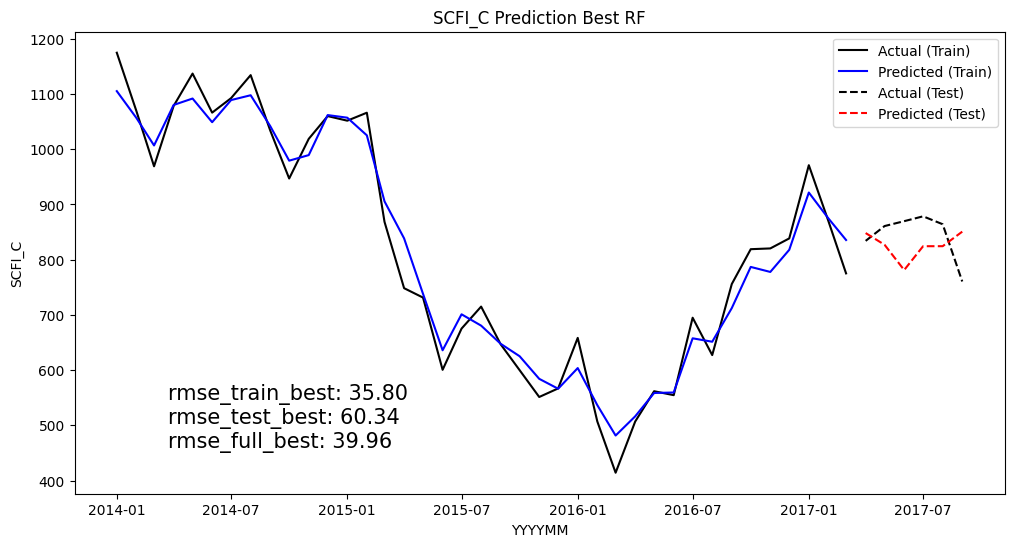

In [ ]:
import matplotlib.pyplot as plt
data_with_months['YYYYMM'] = pd.to_datetime(data_with_months['YYYYMM'])

# 그래프 생성
plt.figure(figsize=(12, 6))   # 그림의 가로의 길이 12인치, 세로의 길이 6인치로 설정
plt.plot(data_with_months['YYYYMM'][:-6], y_train, color='black', label='Actual (Train)')
plt.plot(data_with_months['YYYYMM'][:-6], y_train_pred_best, color='blue', label='Predicted (Train)')
plt.plot(data_with_months['YYYYMM'][-6:], y_test, color='black', label='Actual (Test)', linestyle='dashed')
plt.plot(data_with_months['YYYYMM'][-6:], y_test_pred_best, color='red', label='Predicted (Test)', linestyle='dashed')
plt.xlabel('YYYYMM')
plt.ylabel('SCFI_C')
plt.title('SCFI_C Prediction Best RF')
plt.legend()
#
font_size = 15     # 기본 폰트 크기 10에서 15로 변경
plt.text(0.1, 0.1, f"rmse_train_best: {rmse_train_best:.2f}\n"
                   f"rmse_test_best: {rmse_test_best:.2f}\n"
                   f"rmse_full_best: {rmse_full_best:.2f}",
         fontsize=font_size, transform=plt.gca().transAxes)

# 그래프 표시
plt.show()

plt.show()
# 소수점 둘째자리까지 표시
#print(f"rmse_train_best: {rmse_train_best:.2f}, rmse_test_best: {rmse_test_best:.2f}, rmse_full_best: {rmse_full_best:.2f}")

# **GBM 모형 개발**

In [ ]:
# 데이터 전처리

# 월 추출 및 원-핫 인코딩
data['Month'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m').dt.month
month_one_hot = pd.get_dummies(data['Month'], prefix='Month').iloc[:, 1:]  # 1월 제외

# 원-핫 인코딩된 월 데이터를 원본 데이터에 결합
data_with_months = data.join(month_one_hot)

# 독립변수와 종속변수 분리
X = data_with_months.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)  # 독립변수
y = data_with_months['SCFI_C']  # 종속변수

# 훈련 데이터와 테스트 데이터 분리 (마지막 6행이 테스트 데이터)
X_train, X_test = X[:-6], X[-6:]
y_train, y_test = y[:-6], y[-6:]

# 전처리된 데이터의 일부 확인
X_train.head(), y_train.head()


(     CH_EXP  FLEET_DEV  CNTR_TIMECHART    WTI   R_GDP_WORLD  DEFLATOR_WORLD  \
 0  21790540   17312194        46.79983   94.6  1.787676e+07      109.776667   
 1   9977430   17385239        46.71077  100.8  1.791018e+07      110.063333   
 2  17115050   17367549        46.70015  100.8  1.794359e+07      110.350000   
 3  20089670   17534040        47.20250  102.1  1.799153e+07      110.543333   
 4  20500550   17701139        46.95479  102.2  1.803947e+07      110.736667   
 
      R_GDP_USA   CLI_USA  PMI_US  DEFLATOR_USA  ...  Month_3  Month_4  \
 0  4173.316667  100.7090    53.7    102.690000  ...    False    False   
 1  4168.433333  100.7202    57.1    102.830000  ...    False    False   
 2  4163.550000  100.7613    55.5    102.970000  ...     True    False   
 3  4181.376667  100.8148    55.4    103.163333  ...    False     True   
 4  4199.203333  100.8649    56.4    103.356667  ...    False    False   
 
    Month_5  Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  Mon

# 도표 20-11. GBM회귀모형의 하이퍼파라미터 최적화 파이썬 코드

In [ ]:
# 필요한 클래스와 함수를 sklearn 라이브러리에서 불러오기
from sklearn.ensemble import GradientBoostingRegressor  # 그래디언트 부스팅 회귀 모델
from sklearn.model_selection import GridSearchCV  # 그리드 서치를 통한 하이퍼파라미터 튜닝을 위한 클래스

# 기본 그래디언트 부스팅 모델을 생성
gbm = GradientBoostingRegressor(random_state=0)  # 모델의 재현성을 위해 random_state 설정

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],  # 부스팅 스테이지의 수, 즉 약한 학습기의 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습 속도, 각 모델의 기여도를 조절
    'max_depth': [3, 4, 5],  # 각 트리의 최대 깊이
    'min_samples_split': [2, 4, 6]  # 노드를 분할하기 위해 필요한 최소 샘플 수
}

# 하이퍼파라미터 최적화를 위한 그리드 서치 객체 생성
grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# cv=5는 5-겹 교차 검증을 의미하며, scoring은 모델 성능 평가 기준으로 음수 MSE를 사용
# n_jobs=-1은 가능한 모든 CPU를 사용하여 계산을 가속화

# 그리드 서치 실행: 모델 학습 및 최적 하이퍼파라미터 탐색
grid_search.fit(X_train, y_train)  # X_train은 특성 데이터, y_train은 타겟 데이터

# 최적의 하이퍼파라미터와 그에 해당하는 모델을 추출
best_params = grid_search.best_params_  # 최적의 파라미터 조합
best_gbm = grid_search.best_estimator_  # 최적의 파라미터로 구성된 모델

# 최적의 파라미터와 모델 출력
best_params, best_gbm

({'learning_rate': 0.2,
  'max_depth': 3,
  'min_samples_split': 2,
  'n_estimators': 100},
 GradientBoostingRegressor(learning_rate=0.2, random_state=0))

# 도표 20-12. GBM 회귀모형 학습과 테스트 파이쎤 코드

In [ ]:
# 1안 : 교재 작성 코드
from sklearn.metrics import mean_squared_error  # 평균 제곱 오차 계산 함수
# 최적의 하이퍼파라미터로 모델 정의
gbm_best = GradientBoostingRegressor(learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=100, random_state=0)

# 훈련 데이터에 대한 모델 학습
gbm_best.fit(X_train, y_train)  # X_train은 특성 데이터, y_train은 타겟 데이터

# 훈련데이터 및 테스트데이터 그리고 전체 데이터셋에 대해 예측한다.
y_train_pred_best = gbm_best.predict(X_train)  # 훈련 데이터에 대한 예측
y_test_pred_best = gbm_best.predict(X_test)    # 테스트 데이터에 대한 예측
y_pred_full_best = gbm_best.predict(X)         # X는 전체 데이터셋의 특성 데이터

# 훈련 및 테스트데이터, 그리고 전체 데이터에 대한 RMSE를 계산한다.
rmse_train_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))  # 훈련 데이터 RMSE
rmse_test_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))     # 테스트 데이터 RMSE
rmse_full_best = np.sqrt(mean_squared_error(y, y_pred_full_best))          # 전체 데이터 RMSE

print(f"rmse_train_best: {rmse_train_best:.2f}, rmse_test_best: {rmse_test_best:.2f}, rmse_full_best: {rmse_full_best:.2f}")


rmse_train_best: 0.10, rmse_test_best: 65.99, rmse_full_best: 24.10


(참조용) 도표 20-12와 동일 결과

In [ ]:
# 2안) 신규코드

gbm_best = grid_search.best_estimator_

# 최적의 모델의 파라미터를 추출합니다.
params = gbm_best.get_params()
# 그리드 서치에 포함된 파라미터 중 None이 아닌 파라미터만 필터링하여 출력합니다.
filtered_params = {param: value for param, value in params.items() if param in param_grid and value is not None}
print(filtered_params)

print(grid_search.best_estimator_)


# 훈련 데이터 및 테스트 데이터에 대한 예측
y_train_pred_best = gbm_best.predict(X_train)  # 훈련 데이터에 대한 예측
y_test_pred_best = gbm_best.predict(X_test)  # 테스트 데이터에 대한 예측

# 전체 데이터셋에 대한 예측
y_pred_full_best = gbm_best.predict(X)  # X는 전체 데이터셋의 특성 데이터

# 훈련 및 테스트 데이터에 대한 RMSE 계산
rmse_train_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))  # 훈련 데이터 RMSE
rmse_test_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))  # 테스트 데이터 RMSE

# 전체 데이터셋에 대한 RMSE 계산
rmse_full_best = np.sqrt(mean_squared_error(y, y_pred_full_best))  # 전체 데이터 RMSE

# 결과 출력
print(f"rmse_train_best: {rmse_train_best:.2f}, rmse_test_best: {rmse_test_best:.2f}, rmse_full_best: {rmse_full_best:.2f}")
print(f"rmse_train_best: {rmse_train_best:.7f}, rmse_test_best: {rmse_test_best:.7f}, rmse_full_best: {rmse_full_best:.7f}")

{'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
GradientBoostingRegressor(learning_rate=0.2, random_state=0)
rmse_train_best: 0.10, rmse_test_best: 65.99, rmse_full_best: 24.10
rmse_train_best: 0.0960894, rmse_test_best: 65.9885844, rmse_full_best: 24.0957902


# 도표 20-13. GBM 회귀모형의 예측 결과 시각화

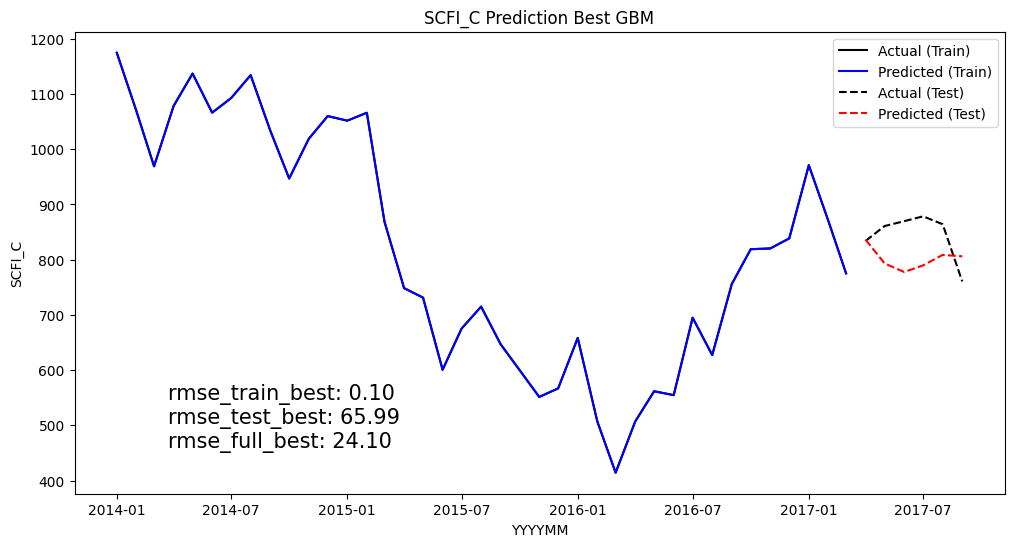

In [ ]:
import matplotlib.pyplot as plt

# YYYYMM 열을 날짜 형식으로 변환
data_with_months['YYYYMM'] = pd.to_datetime(data_with_months['YYYYMM'])
# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(data_with_months['YYYYMM'][:-6], y_train, color='black', label='Actual (Train)')
plt.plot(data_with_months['YYYYMM'][:-6], y_train_pred_best, color='blue', label='Predicted (Train)')
plt.plot(data_with_months['YYYYMM'][-6:], y_test, color='black', label='Actual (Test)', linestyle='dashed')
plt.plot(data_with_months['YYYYMM'][-6:], y_test_pred_best, color='red', label='Predicted (Test)', linestyle='dashed')
plt.xlabel('YYYYMM')
plt.ylabel('SCFI_C')
plt.title('SCFI_C Prediction Best GBM')
plt.legend()
#
font_size = 15     # 기본 폰트 크기 10에서 15로 변경
plt.text(0.1, 0.1, f"rmse_train_best: {rmse_train_best:.2f}\n"
                   f"rmse_test_best: {rmse_test_best:.2f}\n"
                   f"rmse_full_best: {rmse_full_best:.2f}",
         fontsize=font_size, transform=plt.gca().transAxes)

plt.show()
# 소수점 둘째자리까지 표시
# print(f"rmse_train_best: {rmse_train_best:.2f}, rmse_test_best: {rmse_test_best:.2f}, rmse_full_best: {rmse_full_best:.2f}")

(참조용) 전체 데이터로 학습하고, 전체 데이터에 대한 rmse 계산[링크 텍스트](https://)

In [ ]:
# 전체 데이터에 대한 모델 학습
gbm_full = GradientBoostingRegressor(learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=100, random_state=0)
gbm_full.fit(X, y)

# 전체 데이터에 대한 예측
y_pred_full = gbm_full.predict(X)

# 전체 데이터에 대한 RMSE 계산
rmse_full = np.sqrt(mean_squared_error(y, y_pred_full))

rmse_full


0.2759154450901788

## **XGBoost 모형 개발**

In [ ]:
# Extract the month and create one-hot encoded columns
data['Month'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m').dt.month
month_one_hot = pd.get_dummies(data['Month'], prefix='Month').iloc[:, 1:]  # Excluding the first column (January)

# Join the one-hot encoded columns with the original dataframe
data_with_months = data.join(month_one_hot)

# Prepare the data for modeling
X = data_with_months.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)  # Independent variables
y = data_with_months['SCFI_C']  # Dependent variable

# Splitting the data into training and test sets
# The last 6 rows are separated as test data
X_train, X_test = X[:-6], X[-6:]
y_train, y_test = y[:-6], y[-6:]

X_train.head()


,CH_EXP,FLEET_DEV,CNTR_TIMECHART,WTI,R_GDP_WORLD,DEFLATOR_WORLD,R_GDP_USA,CLI_USA,PMI_US,DEFLATOR_USA,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,21790540,17312194,46.79983,94.6,1.787676e+07,109.776667,4173.316667,100.7090,53.7,102.690000,...,False,False,False,False,False,False,False,False,False,False
1,9977430,17385239,46.71077,100.8,1.791018e+07,110.063333,4168.433333,100.7202,57.1,102.830000,...,False,False,False,False,False,False,False,False,False,False
2,17115050,17367549,46.70015,100.8,1.794359e+07,110.350000,4163.550000,100.7613,55.5,102.970000,...,True,False,False,False,False,False,False,False,False,False
3,20089670,17534040,47.20250,102.1,1.799153e+07,110.543333,4181.376667,100.8148,55.4,103.163333,...,False,True,False,False,False,False,False,False,False,False
4,20500550,17701139,46.95479,102.2,1.803947e+07,110.736667,4199.203333,100.8649,56.4,103.356667,...,False,False,True,False,False,False,False,False,False,False


# 도표 20-14. XGBoost회귀모형의 하이퍼파라미터 최적화 파이썬 코드

In [ ]:
# 필요한 라이브러리를 불러오기
from xgboost import XGBRegressor  # XGBoost 회귀 모델
from sklearn.model_selection import GridSearchCV  # 그리드 서치를 통한 하이퍼파라미터 튜닝을 위한 클래스
from sklearn.metrics import mean_squared_error  # 평균 제곱 오차 계산 함수
import numpy as np  # 수치 계산을 위한 라이브러리

# XGBoost 회귀 모델 설정
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)  # 목표는 제곱 오차 최소화

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 부스팅 스테이지의 수, 즉 약한 학습기의 개수
    'max_depth': [3, 4, 5],  # 각 트리의 최대 깊이
    'learning_rate': [0.01, 0.05, 0.1],  # 학습 속도, 각 모델의 기여도를 조절
    'colsample_bytree': [0.7, 0.8, 0.9]  # 트리를 구성하는데 사용할 특성의 비율
}

# 5-겹 교차 검증을 사용하는 그리드 서치 설정: verbose=1은 진행 과정 출력
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# 데이터에 그리드 서치 적용
grid_search.fit(X_train, y_train)  # X_train은 특성 데이터, y_train은 타겟 데이터

# 최적의 모델 추출
best_xgb = grid_search.best_estimator_  # 최적의 하이퍼파라미터로 설정된 모델

# 최적의 모델의 파라미터를 추출합니다.
params = best_xgb.get_params()

# 그리드 서치에 포함된 파라미터 중 None이 아닌 파라미터만 필터링하여 출력합니다.
filtered_params = {param: value for param, value in params.items()
  if param in param_grid and value is not None}
print(filtered_params)
print(best_xgb)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


# 도표 20-15. XGBoost 회귀모형 학습과 테스트 파이쎤 코드

In [ ]:
# 도표 20-15. XGBoost 회귀모형 학습과 테스트 파이쎤 코드
# 훈련 데이터 및 테스트 데이터에 대한 예측
y_train_pred_best = best_xgb.predict(X_train)
y_test_pred_best = best_xgb.predict(X_test)
# Predicting on the entire dataset with the best model
y_pred_full_best = best_xgb.predict(X)

# Calculating RMSE for the train & test data with the best model
rmse_train_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
rmse_test_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
# Calculating RMSE for the entire dataset with the best model
rmse_full_best = np.sqrt(mean_squared_error(y, y_pred_full_best))
# 소수점 둘째자리까지 표시
print(f"rmse_train_best: {rmse_train_best:.2f}, rmse_test_best: {rmse_test_best:.2f}, rmse_full_best: {rmse_full_best:.2f}")

rmse_train_best: 1.41, rmse_test_best: 61.32, rmse_full_best: 22.43


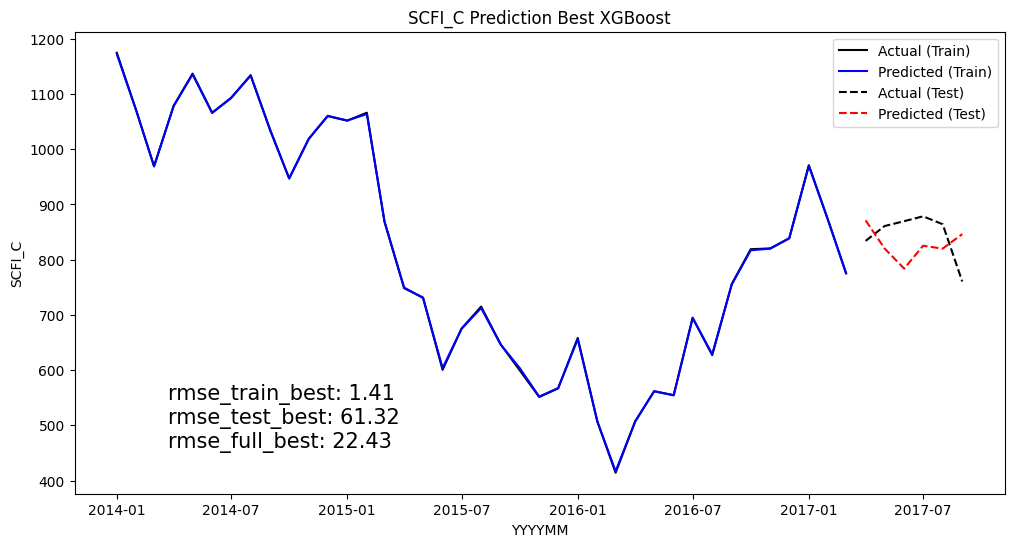

In [ ]:
# YYYYMM 열을 날짜 형식으로 변환
data_with_months['YYYYMM'] = pd.to_datetime(data_with_months['YYYYMM'])

plt.figure(figsize=(12, 6))
plt.plot(data_with_months['YYYYMM'][:-6], y_train, color='black', label='Actual (Train)')
plt.plot(data_with_months['YYYYMM'][:-6], y_train_pred_best, color='blue', label='Predicted (Train)')
plt.plot(data_with_months['YYYYMM'][-6:], y_test, color='black', label='Actual (Test)', linestyle='dashed')
plt.plot(data_with_months['YYYYMM'][-6:], y_test_pred_best, color='red', label='Predicted (Test)', linestyle='dashed')
plt.xlabel('YYYYMM')
plt.ylabel('SCFI_C')
plt.title('SCFI_C Prediction Best XGBoost')
plt.legend()
#
font_size = 15     # 기본 폰트 크기 10에서 15로 변경
plt.text(0.1, 0.1, f"rmse_train_best: {rmse_train_best:.2f}\n"
                   f"rmse_test_best: {rmse_test_best:.2f}\n"
                   f"rmse_full_best: {rmse_full_best:.2f}",
         fontsize=font_size, transform=plt.gca().transAxes)

plt.show()
# 소수점 둘째자리까지 표시
# print(f"rmse_train_best: {rmse_train_best:.2f}, rmse_test_best: {rmse_test_best:.2f}, rmse_full_best: {rmse_full_best:.2f}")

In [ ]:
# 변수 이름 리스트 정의 (예: X_train의 컬럼 이름 사용)
features = X_train.columns.tolist()

# 랜덤 포레스트와 그래디언트 부스팅 모델의 변수 중요도
rf_feature_importances = best_rf_model.feature_importances_
gb_feature_importances = gbm_best.feature_importances_

# 중요도와 변수명을 DataFrame으로 변환
rf_importances = pd.DataFrame({'Feature': features, 'Importance': rf_feature_importances})
gb_importances = pd.DataFrame({'Feature': features, 'Importance': gb_feature_importances})

# 중요도 순으로 정렬
rf_sorted_importances = rf_importances.sort_values(by='Importance', ascending=False)
gb_sorted_importances = gb_importances.sort_values(by='Importance', ascending=False)

# 중요변수 리스트로 변환
rf_important_features = rf_sorted_importances['Feature'].tolist()
gb_important_features = gb_sorted_importances['Feature'].tolist()

rf_important_features, gb_important_features



(['DEFLATOR_WORLD',
  'G_RELI',
  'CLI_USA',
  'PMI_US',
  'DEFLATOR_USA',
  'R_GDP_USA',
  'R_GDP_WORLD',
  'FLEET_DEV',
  'WTI',
  'CNTR_TIMECHART',
  'G_DELAY',
  'CH_EXP',
  'Month_3',
  'Month_10',
  'Month_7',
  'Month_6',
  'Month_5',
  'Month_11',
  'Month_2',
  'Month_4',
  'Month_8',
  'Month_9',
  'Month_12'],
 ['DEFLATOR_WORLD',
  'R_GDP_USA',
  'R_GDP_WORLD',
  'DEFLATOR_USA',
  'FLEET_DEV',
  'G_DELAY',
  'PMI_US',
  'G_RELI',
  'CH_EXP',
  'CLI_USA',
  'WTI',
  'Month_3',
  'CNTR_TIMECHART',
  'Month_8',
  'Month_10',
  'Month_4',
  'Month_6',
  'Month_7',
  'Month_5',
  'Month_11',
  'Month_2',
  'Month_12',
  'Month_9'])

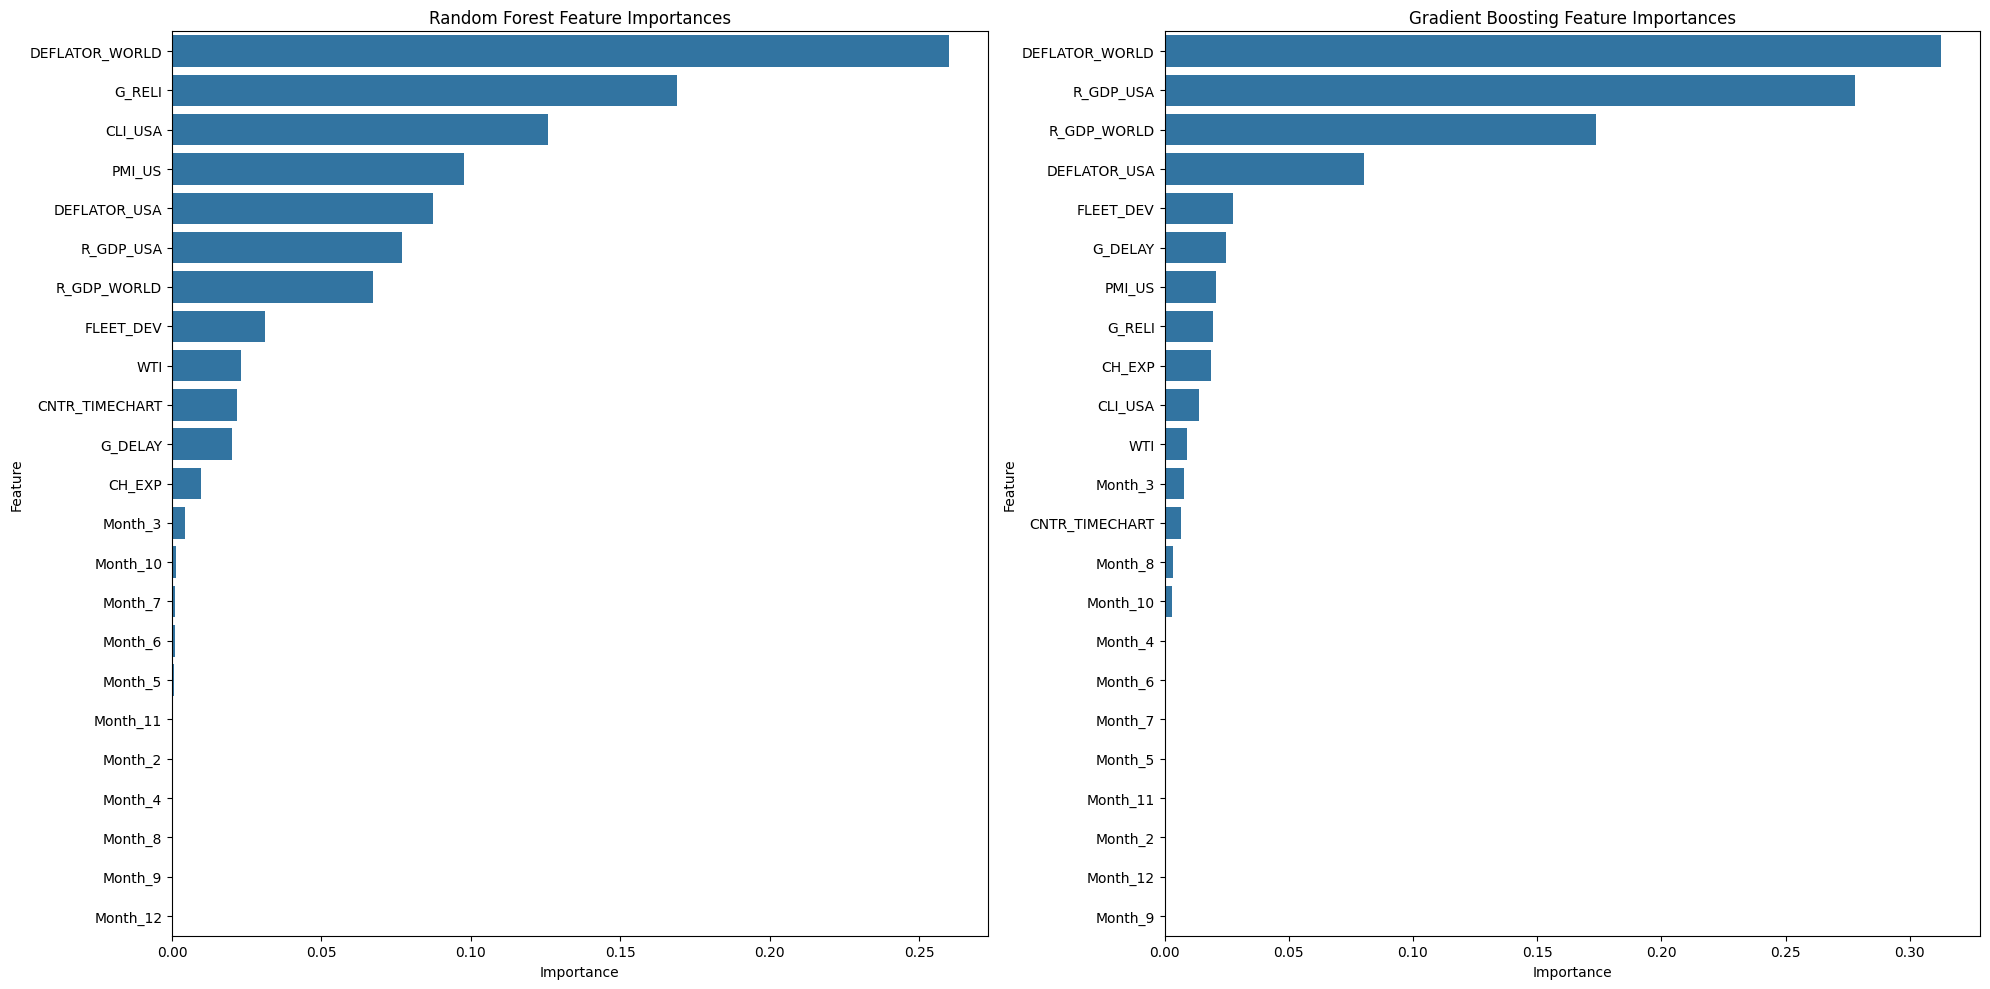

In [ ]:
import seaborn as sns
# 변수 중요도 비교를 위한 그래프 생성
# 플롯 설정
plt.figure(figsize=(20, 10))

# 랜덤 포레스트 변수 중요도 그래프
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=rf_sorted_importances)
plt.title('Random Forest Feature Importances')

# 그래디언트 부스팅 변수 중요도 그래프
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=gb_sorted_importances)
plt.title('Gradient Boosting Feature Importances')

plt.tight_layout()
plt.show()



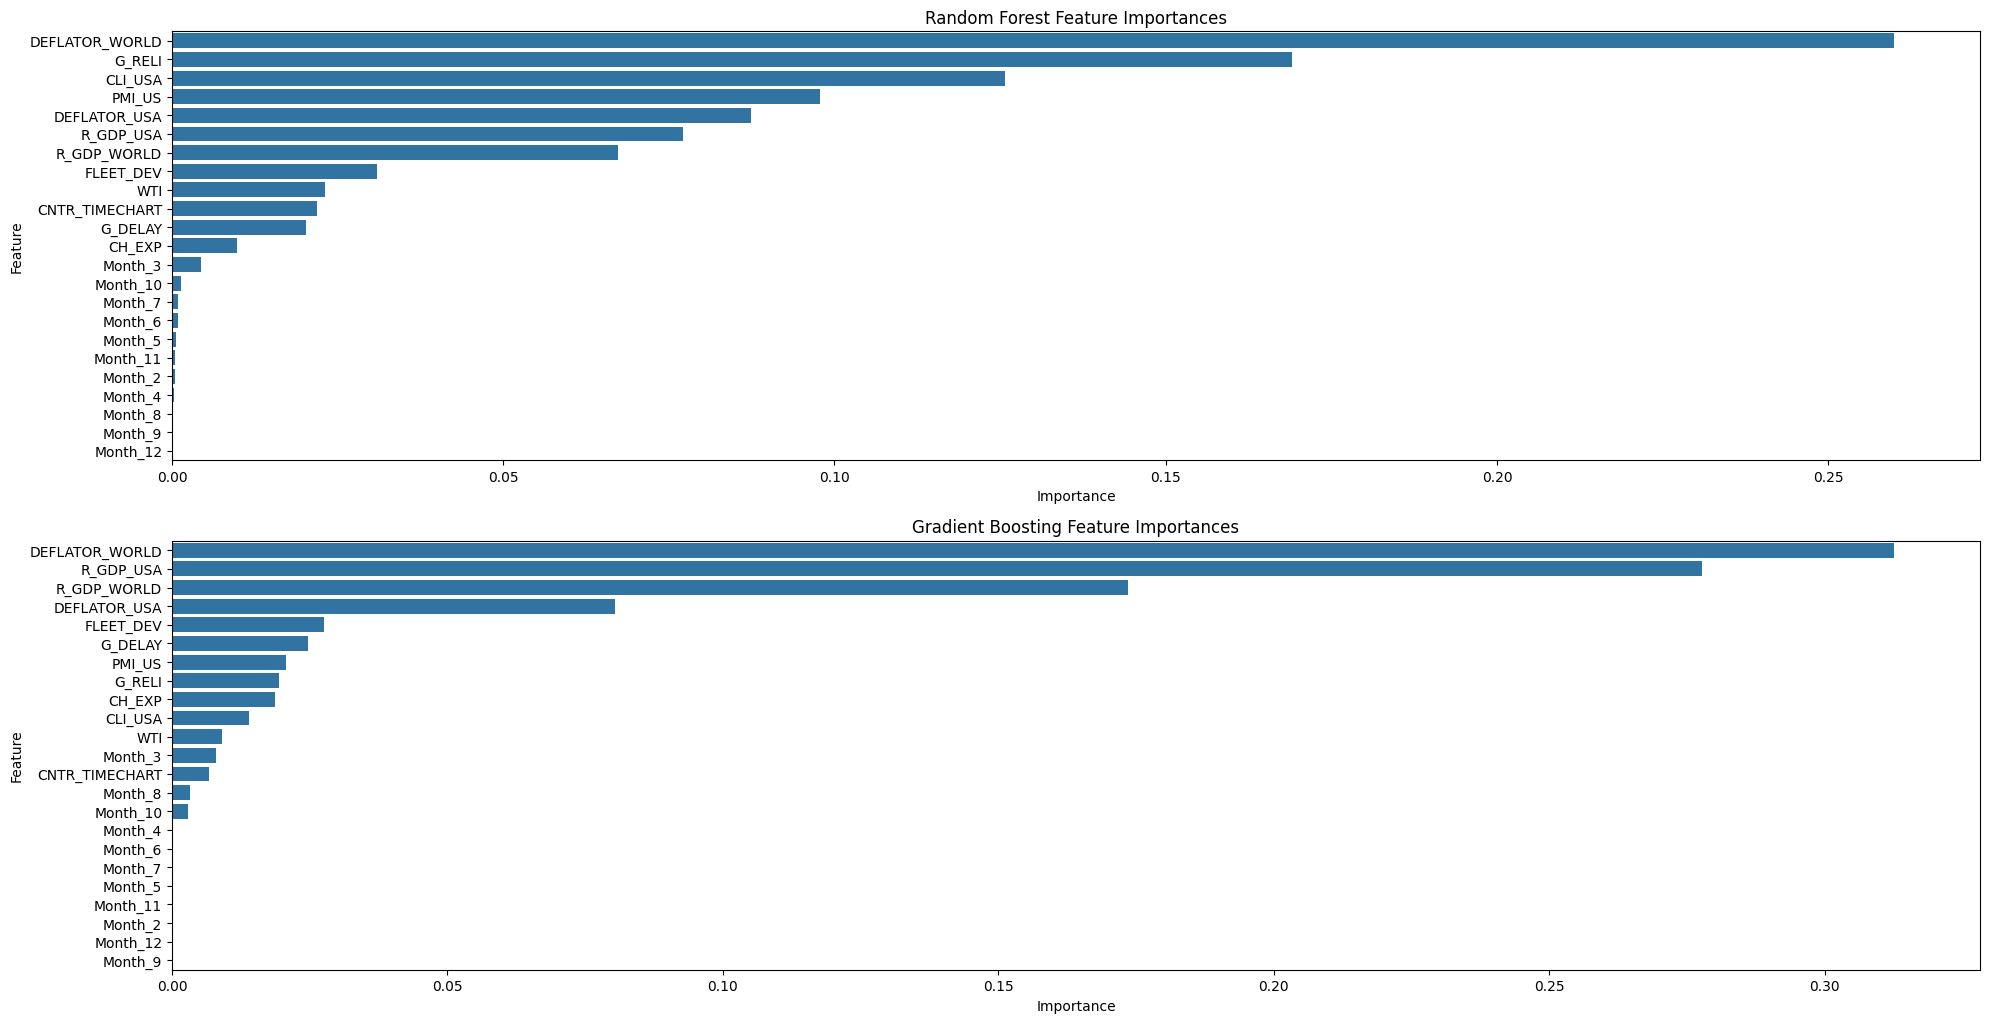

In [ ]:
plt.figure(figsize=(20, 15))

# 랜덤 포레스트 변수 중요도 그래프
plt.subplot(3, 1, 1)
sns.barplot(x='Importance', y='Feature', data=rf_sorted_importances)
plt.title('Random Forest Feature Importances')

# 그래디언트 부스팅 변수 중요도 그래프
plt.subplot(3, 1, 2)
sns.barplot(x='Importance', y='Feature', data=gb_sorted_importances)
plt.title('Gradient Boosting Feature Importances')

plt.tight_layout()
plt.show()

In [ ]:
# 수정된 선형 회귀 모델의 예측값 생성
lr_predictions_scaled = lr_model_scaled.predict(X_final)

# 플롯 설정
plt.figure(figsize=(15, 7))

# 실제값 (검은색)
plt.plot(dates, y, 'k-', label='Actual')

# 랜덤 포레스트 예측값
plt.plot(dates[train_mask], rf_train_pred, 'b-', label='RF Train Predictions')
plt.plot(dates[test_mask], rf_test_pred, 'r-', label='RF Test Predictions')

# 그래디언트 부스팅 예측값
plt.plot(dates[train_mask], gb_train_pred, 'b--', label='GB Train Predictions')
plt.plot(dates[test_mask], gb_test_pred, 'r--', label='GB Test Predictions')

# 수정된 선형 회귀 예측값
plt.plot(dates[train_mask], lr_predictions_scaled[train_mask], 'b:', label='LR Scaled Train Predictions')
plt.plot(dates[test_mask], lr_predictions_scaled[test_mask], 'r:', label='LR Scaled Test Predictions')

# 그래프 제목 및 레이블
plt.title('SCFI Predictions - RF, GB, and Scaled LR Models')
plt.xlabel('Date (YYYYMM)')
plt.ylabel('SCFI')
plt.legend()

# 그래프 표시
plt.show()


In [ ]:
# 선형 회귀 모델의 변수 중요도(계수의 절대값) 재계산
lr_importances_scaled = pd.DataFrame({'Feature': scaled_features, 'Importance': np.abs(lr_coefficients_scaled)})
lr_sorted_importances_scaled = lr_importances_scaled.sort_values(by='Importance', ascending=False)

# 변수 중요도 비교를 위한 그래프 생성

# 플롯 설정
plt.figure(figsize=(20, 15))

# 랜덤 포레스트 변수 중요도 그래프
plt.subplot(3, 1, 1)
sns.barplot(x='Importance', y='Feature', data=rf_sorted_importances)
plt.title('Random Forest Feature Importances')

# 그래디언트 부스팅 변수 중요도 그래프
plt.subplot(3, 1, 2)
sns.barplot(x='Importance', y='Feature', data=gb_sorted_importances)
plt.title('Gradient Boosting Feature Importances')

# 수정된 선형 회귀 변수 중요도(계수 절대값) 그래프
plt.subplot(3, 1, 3)
sns.barplot(x='Importance', y='Feature', data=lr_sorted_importances_scaled)
plt.title('Scaled Linear Regression Coefficient Magnitudes')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# 원-핫 인코딩된 변수를 제외한 변수에 대해 로그 변환
X_log_transformed = np.log(X.drop(one_hot_columns, axis=1))

# 로그 변환된 데이터프레임 재생성 (컬럼 이름 유지)
X_log_transformed_df = pd.DataFrame(X_log_transformed, columns=X.columns.drop(one_hot_columns))

# 원-핫 인코딩된 데이터와 합치기
X_log_final = pd.concat([X_log_transformed_df, X[one_hot_columns]], axis=1)

# 로그 변환된 데이터를 사용하여 선형 회귀 모델 훈련
lr_model_log_transformed = LinearRegression()
lr_model_log_transformed.fit(X_log_final, y)

# 훈련된 선형 회귀 모델의 계수 및 절편
lr_coefficients_log_transformed = lr_model_log_transformed.coef_
lr_intercept_log_transformed = lr_model_log_transformed.intercept_

# 계수를 사용한 회귀식 생성
log_transformed_features = X_log_final.columns
regression_formula_log_transformed = f"y = {lr_intercept_log_transformed:.2f} "
for coef, feature in zip(lr_coefficients_log_transformed, log_transformed_features):
    regression_formula_log_transformed += f"+ ({coef:.2f}) * {feature} "

regression_formula_log_transformed



In [ ]:
# 로그 변환 선형 회귀 모델의 전체 데이터에 대한 예측값 생성
lr_predictions_log_transformed = lr_model_log_transformed.predict(X_log_final)

# 플롯 설정
plt.figure(figsize=(15, 7))

# 실제값 (검은색)
plt.plot(dates, y, 'k-', label='Actual')

# 랜덤 포레스트 예측값
plt.plot(dates[train_mask], rf_train_pred, 'b-', label='RF Train Predictions')
plt.plot(dates[test_mask], rf_test_pred, 'r-', label='RF Test Predictions')

# 그래디언트 부스팅 예측값
plt.plot(dates[train_mask], gb_train_pred, 'b--', label='GB Train Predictions')
plt.plot(dates[test_mask], gb_test_pred, 'r--', label='GB Test Predictions')

# 로그 변환 선형 회귀 예측값
plt.plot(dates[train_mask], lr_predictions_log_transformed[train_mask], 'b:', label='LR Log Transformed Train Predictions')
plt.plot(dates[test_mask], lr_predictions_log_transformed[test_mask], 'r:', label='LR Log Transformed Test Predictions')

# 그래프 제목 및 레이블
plt.title('SCFI Predictions - RF, GB, and Log Transformed LR Models')
plt.xlabel('Date (YYYYMM)')
plt.ylabel('SCFI')
plt.legend()

# 그래프 표시
plt.show()


In [ ]:
# 로그 변환 선형 회귀 모델의 변수 중요도(계수의 절대값) 재계산
lr_importances_log_transformed = pd.DataFrame({'Feature': log_transformed_features, 'Importance': np.abs(lr_coefficients_log_transformed)})
lr_sorted_importances_log_transformed = lr_importances_log_transformed.sort_values(by='Importance', ascending=False)

# 변수 중요도 비교를 위한 그래프 생성

# 플롯 설정
plt.figure(figsize=(20, 15))

# 랜덤 포레스트 변수 중요도 그래프
plt.subplot(3, 1, 1)
sns.barplot(x='Importance', y='Feature', data=rf_sorted_importances)
plt.title('Random Forest Feature Importances')

# 그래디언트 부스팅 변수 중요도 그래프
plt.subplot(3, 1, 2)
sns.barplot(x='Importance', y='Feature', data=gb_sorted_importances)
plt.title('Gradient Boosting Feature Importances')

# 로그 변환 선형 회귀 변수 중요도(계수 절대값) 그래프
plt.subplot(3, 1, 3)
sns.barplot(x='Importance', y='Feature', data=lr_sorted_importances_log_transformed)
plt.title('Log Transformed Linear Regression Coefficient Magnitudes')

plt.tight_layout()
plt.show()


In [ ]:
# 종속변수에 대한 로그 변환
y_log = np.log(y)

# 독립변수(로그 변환된) 및 종속변수(로그 변환된)를 사용하여 선형 회귀 모델 훈련
lr_model_log_log = LinearRegression()
lr_model_log_log.fit(X_log_final, y_log)

# 훈련된 선형 회귀 모델의 계수 및 절편
lr_coefficients_log_log = lr_model_log_log.coef_
lr_intercept_log_log = lr_model_log_log.intercept_

# 계수를 사용한 회귀식 생성
regression_formula_log_log = f"log(Y) = {lr_intercept_log_log:.2f} "
for coef, feature in zip(lr_coefficients_log_log, log_transformed_features):
    regression_formula_log_log += f"+ ({coef:.2f}) * log({feature}) "

regression_formula_log_log



In [ ]:
# 훈련 및 테스트 데이터에 대한 로그-로그 모델의 예측
lr_train_pred_log_log = lr_model_log_log.predict(X_log_final.iloc[:-6])
lr_test_pred_log_log = lr_model_log_log.predict(X_log_final.iloc[-6:])

# 훈련 및 테스트 데이터의 실제 로그 변환된 y 값
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# 훈련 및 테스트 데이터에 대한 RMSE 계산
lr_train_rmse_log_log = np.sqrt(mean_squared_error(y_train_log, lr_train_pred_log_log))
lr_test_rmse_log_log = np.sqrt(mean_squared_error(y_test_log, lr_test_pred_log_log))

lr_train_rmse_log_log, lr_test_rmse_log_log

